# Ultimate Inc. User Engagement Data Analysis

## Import Packages

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing
import json

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 150)
sns.set_palette(palette)

## Load Data

In [2]:
# Check csv files
data_dir = 'Data/*'
! ls {data_dir}

Data/logins.json                  Data/ultimate_data_challenge.json


## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
df_login = pd.read_json('Data/logins.json')
print(df_login.head(10))
print(df_login.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
5 1970-01-01 20:21:41
6 1970-01-01 20:12:16
7 1970-01-01 20:35:47
8 1970-01-01 20:35:38
9 1970-01-01 20:47:52
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB
None


In [4]:
df_login = df_login.sort_values(by = 'login_time')
df_login = df_login.set_index('login_time')
df_login['cnt'] = 1

print(df_login.head(10))

                     cnt
login_time              
1970-01-01 20:12:16    1
1970-01-01 20:13:18    1
1970-01-01 20:16:10    1
1970-01-01 20:16:36    1
1970-01-01 20:16:37    1
1970-01-01 20:21:41    1
1970-01-01 20:26:05    1
1970-01-01 20:26:21    1
1970-01-01 20:31:03    1
1970-01-01 20:34:46    1


In [5]:
def resample(data, rule):
    data_resample = data.resample(rule).count()
    data_resample.plot(figsize = (20, 8), title = 'Number of Login Counts based on ' + rule + ' Time Intervals')
    print(data_resample.head())
    print(data_resample.tail())

                     cnt
login_time              
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                     cnt
login_time              
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6


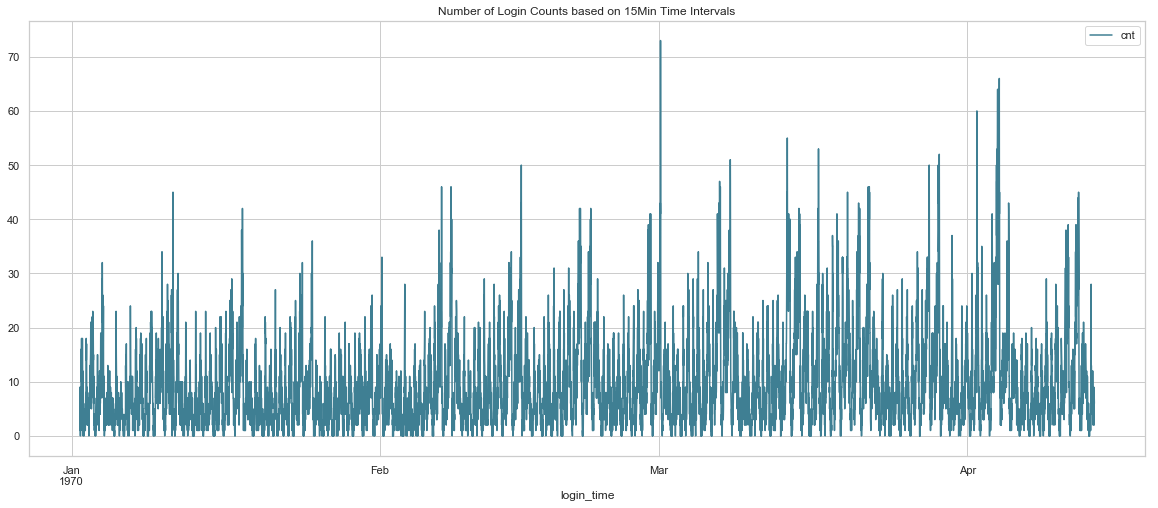

In [6]:
resample(df_login, '15Min')

From the above plot, it seems that there're some patterns of login counts but it's hard to directly tell from the above plot which is counted based on 15 min time intermals.

As time can be classify into min, hr, day, weekday, weekend and month. Let's try to aggregate by differnt time intervals.

                     cnt
login_time              
1970-01-01 20:00:00   24
1970-01-01 21:00:00    9
1970-01-01 22:00:00   21
1970-01-01 23:00:00   58
1970-01-02 00:00:00   53
                     cnt
login_time              
1970-04-13 14:00:00   32
1970-04-13 15:00:00   19
1970-04-13 16:00:00   22
1970-04-13 17:00:00   22
1970-04-13 18:00:00   20


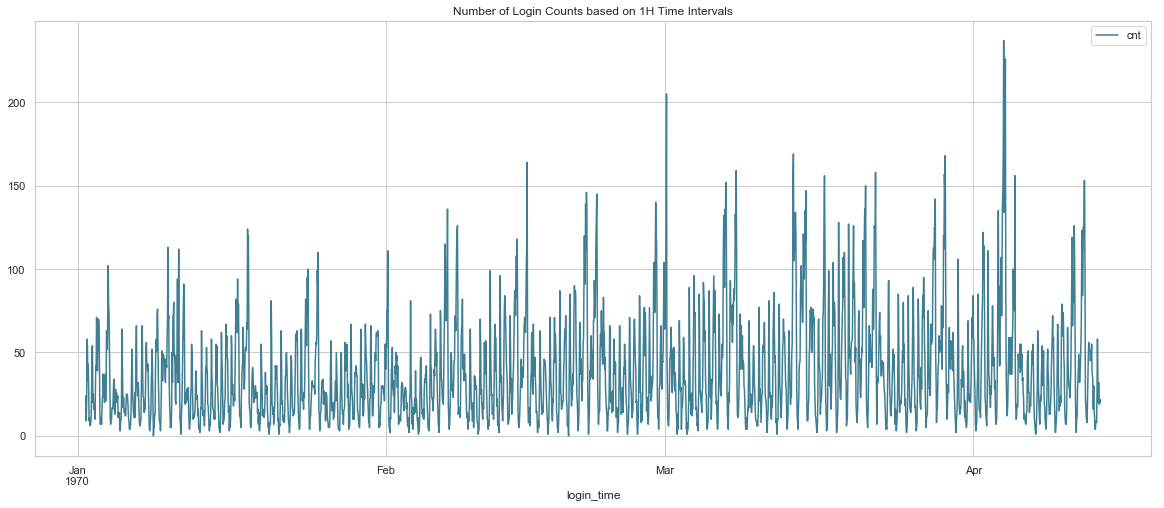

In [7]:
resample(df_login, '1H')

            cnt
login_time     
1970-01-01  112
1970-01-02  681
1970-01-03  793
1970-01-04  788
1970-01-05  459
             cnt
login_time      
1970-04-09   818
1970-04-10  1009
1970-04-11  1352
1970-04-12  1409
1970-04-13   395


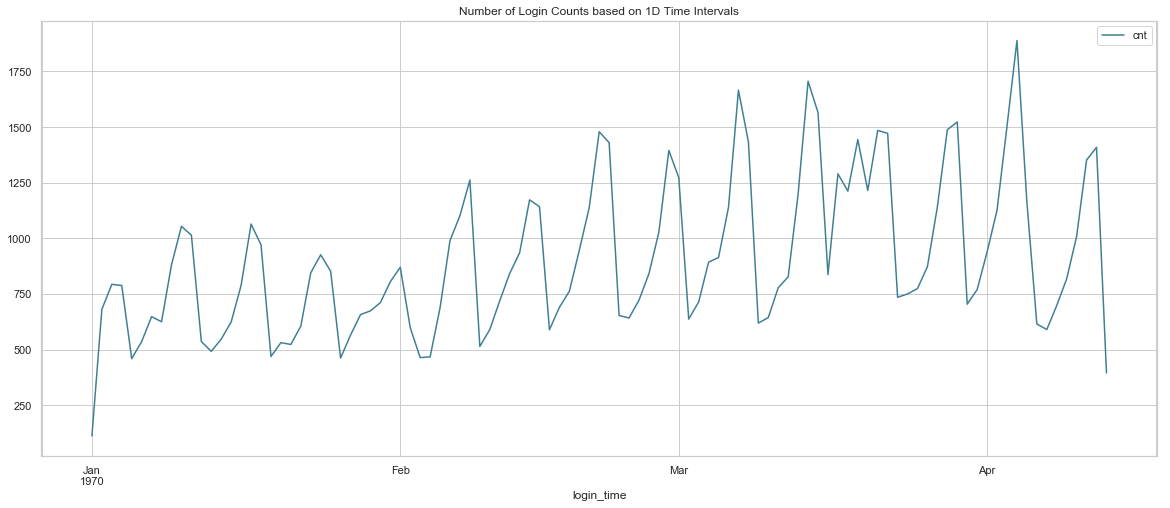

In [8]:
# resample based on 1day time intervals.
resample(df_login, '1D')

By looking at login count per days. Apparently there're some patteerns which are very similar to week period since there are always 4 to 5 peaks in a month. Let's take a closer look:

             cnt
login_time      
1970-02-01   870
1970-02-02   599
1970-02-03   464
1970-02-04   467
1970-02-05   688
1970-02-06   990
1970-02-07  1102
1970-02-08  1262
1970-02-09   514
1970-02-10   590
1970-02-11   719
1970-02-12   842
1970-02-13   935
1970-02-14  1173
1970-02-15  1142
1970-02-16   589
1970-02-17   690
1970-02-18   762
1970-02-19   946
1970-02-20  1139
1970-02-21  1479
1970-02-22  1430
1970-02-23   653
1970-02-24   642
1970-02-25   722
1970-02-26   841
1970-02-27  1028
1970-02-28  1395
1970-03-01  1273


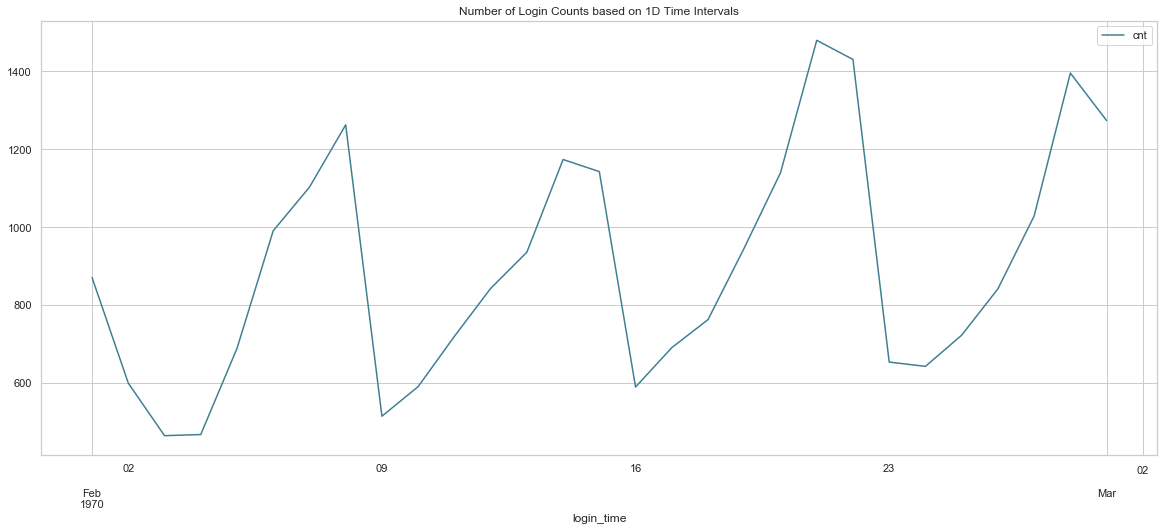

In [9]:
df_login_temp = df_login['1970-02-01': '1970-03-01'].resample('1D').count()
df_login_temp.plot(figsize = (20, 8), title = 'Number of Login Counts based on ' + '1D' + ' Time Intervals')
print(df_login_temp.head(50))

Yes there are apparent patterns within a 7 day period.

Let's print out the weekday to check:

In [10]:
# Get weekday. The day of the week with Monday=0, Sunday=6
df_login_temp = df_login['1970-02-01': '1970-03-01'].resample('1D').count()
df_login_temp['weekday'] = df_login_temp.index.weekday
print(df_login_temp.head(50))

             cnt  weekday
login_time               
1970-02-01   870        6
1970-02-02   599        0
1970-02-03   464        1
1970-02-04   467        2
1970-02-05   688        3
1970-02-06   990        4
1970-02-07  1102        5
1970-02-08  1262        6
1970-02-09   514        0
1970-02-10   590        1
1970-02-11   719        2
1970-02-12   842        3
1970-02-13   935        4
1970-02-14  1173        5
1970-02-15  1142        6
1970-02-16   589        0
1970-02-17   690        1
1970-02-18   762        2
1970-02-19   946        3
1970-02-20  1139        4
1970-02-21  1479        5
1970-02-22  1430        6
1970-02-23   653        0
1970-02-24   642        1
1970-02-25   722        2
1970-02-26   841        3
1970-02-27  1028        4
1970-02-28  1395        5
1970-03-01  1273        6


Yes the login count appears to be higher on weekends and lower on weekdays, repeatedly.

After identifying the pattern of week, let's see what's the daily pattern of weekdays vs. weekends.

In [11]:
# Get data of one week, resample based on 1 Hour time intervals and plot for each weekday.
def get_sub_plot(width = 16, height = 5, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

def plot_cnt_per_hour(data):
    dates = list(set(data.index.date))

    ax = get_sub_plot()

    for date in dates:
        data_per_day = data[str(date): str(date)].resample('1H').count()
        sns.lineplot(data = data_per_day, x = data_per_day.index.hour, y = 'cnt', ax = ax)

    plt.show()

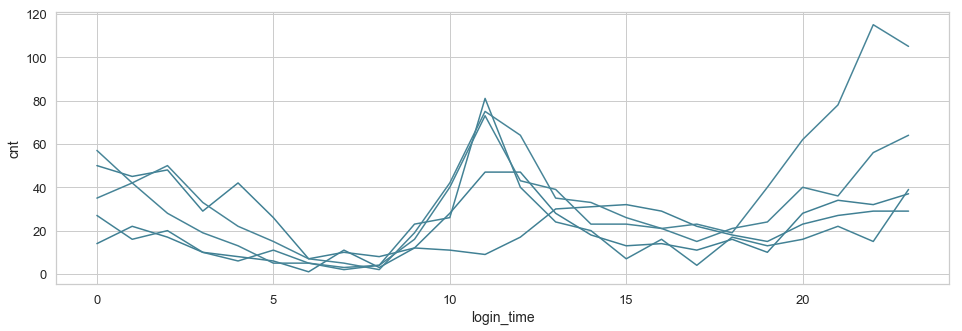

In [12]:
df_login_mon_to_thur = df_login['1970-02-02': '1970-02-06']
plot_cnt_per_hour(df_login_mon_to_thur)

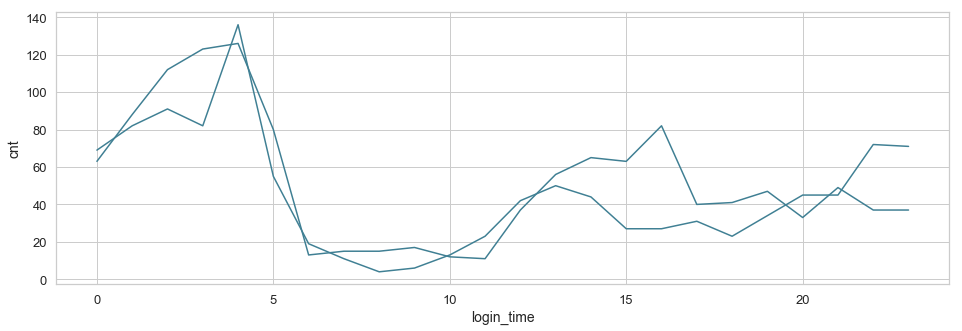

In [13]:
df_login_mon_to_thur = df_login['1970-02-07': '1970-02-08']
plot_cnt_per_hour(df_login_mon_to_thur)

Interestingly the login count pattern is also pretty consistent.

On weekdays there's a peak at noon. On weekends there's a peak in the early morning.

Let's confirm by checking another week:

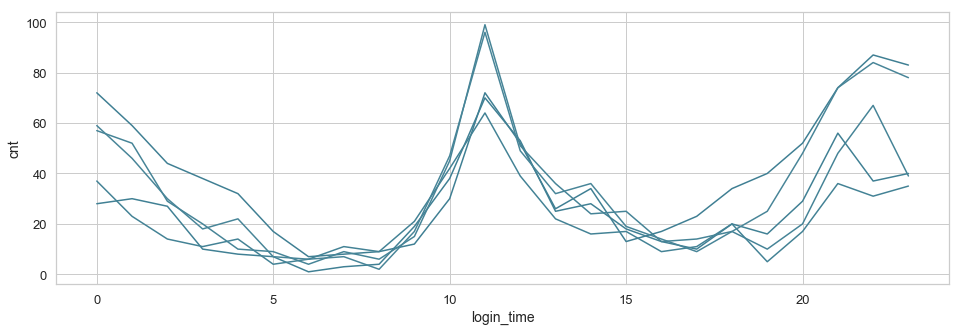

In [14]:
df_login_mon_to_thur = df_login['1970-02-09': '1970-02-13']
plot_cnt_per_hour(df_login_mon_to_thur)

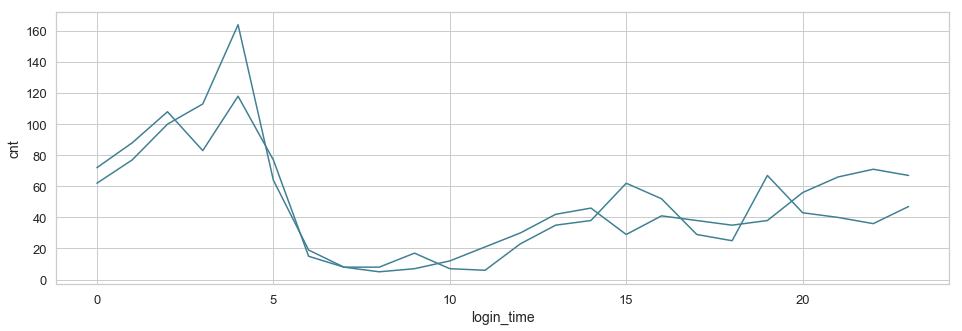

In [15]:
df_login_mon_to_thur = df_login['1970-02-14': '1970-02-15']
plot_cnt_per_hour(df_login_mon_to_thur)

Yes the following week still follows the same pattern.

> Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

**The time of login history spans from 1970-01-01 to 1970-04-13. There are total 93142 logins.**

**When resampling based on 1day time intervals, we can see apparent pattern with a 7-day period. To be more specific, the login count appears to be higher on weekends and lower on weekdays, repeatedly in a 7-day period.**

**When resmapling based on 1 Hr timg intervals on weekdays, apparently there is a peak of login count at noon, while on weekends, there is a peak in the early morning.**

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  * how you will implement the experiment
  * what statistical test(s) you will conduct to verify the significance of the observation
  * how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Let's first work on the metric:

> 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

** The key metric I would use is the product profitability.**

> 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  * how you will implement the experiment
  * what statistical test(s) you will conduct to verify the significance of the observation
  * how you would interpret the results and provide recommendations to the city operations team along with any caveats.
  
The key measure of success in this experiment would be profit. The first two times a driver partner took advantage of the reimbursement policy would be to test it out, to decide for themselves through experience if the trip was made worth the cost and time because of a toll reimbursement.

Does consistent toll reimbursement encourage driver partners to expand their geographic range of service? Some driver partners may decide the reimbursement is not worth it, in which case, the overall indicator that the experiment was a general success would be found in profit increase. If the profit does not change, then Ultimate would be able to see that toll reimbursements are not enough to encourage driver partners to cross cities.

I would implement the experiment as followed,

**assuming we have the data of the profit before and after starting to reimburse the toll cost to driver parters,**

**Null hypothesis: Reimbursing all toll costs to driver parters to encourage them to be available in both cities would NOT increase the total profit.**

** Alternate Hypothosis: Reimbursing all toll costs to driver parters to encourage them to be available in both cities would increase the total profit.**

** Test Statistic: Profit mean**

**If p-value is less than 0.05, we can reject the null hypothesis and prove that reimbursing all toll costs to drivers would increase the profit.**

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; **we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.**

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

## Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

## Load Data

In [16]:
data_dir = 'Data/*'
! ls {data_dir}

Data/logins.json                  Data/ultimate_data_challenge.json


In [17]:
with open('Data/ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
df_rider = pd.DataFrame(data)
df_rider.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [18]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
df_rider.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


## Data Wrangling
> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [20]:
# Encode categorical data
categorical_columns = ['city', 'phone']
df_rider = pd.get_dummies(df_rider, columns = categorical_columns)

In [21]:
df_rider.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0


In [22]:
date_columns = ['last_trip_date', 'signup_date']

for col in date_columns:
    df_rider[col] = pd.to_datetime(df_rider[col])

In [23]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), uint8(5)
memory usage: 3.7 MB


In [24]:
# Remove data with missing values
df_rider = df_rider.dropna()
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 15 columns):
avg_dist                  41744 non-null float64
avg_rating_by_driver      41744 non-null float64
avg_rating_of_driver      41744 non-null float64
avg_surge                 41744 non-null float64
last_trip_date            41744 non-null datetime64[ns]
signup_date               41744 non-null datetime64[ns]
surge_pct                 41744 non-null float64
trips_in_first_30_days    41744 non-null int64
ultimate_black_user       41744 non-null bool
weekday_pct               41744 non-null float64
city_Astapor              41744 non-null uint8
city_King's Landing       41744 non-null uint8
city_Winterfell           41744 non-null uint8
phone_Android             41744 non-null uint8
phone_iPhone              41744 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), uint8(5)
memory usage: 3.4 MB


In [25]:
# Check is there is outliers
df_rider.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
count,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000
mean,5.465312,4.776648,4.601801,1.073697,8.884695,2.611393,61.304437,0.325795,0.211503,0.462701,0.289694,0.703143
std,5.149810,0.404109,0.616079,0.198681,18.309042,4.060121,34.799944,0.468677,0.408379,0.498613,0.453626,0.456878
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.790000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Seems to be fine. Let's proceed to define retained users.

## Define Retained Users

> Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; **we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.**

In [26]:
# Get maximum last trip date in the column 'last_trip_date'
max_last_trip_date = max(df_rider['last_trip_date'])
print(max_last_trip_date)

2014-07-01 00:00:00


In [27]:
# Calculate the starting days of 'preceding 30 days'.
preceding_30_days = max_last_trip_date - pd.Timedelta('30 days')
print(preceding_30_days)

2014-06-01 00:00:00


In [28]:
df_rider['retained'] = df_rider['last_trip_date'] > preceding_30_days
df_rider.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1,True
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0,False
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1,False
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1,True
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0,False


In [29]:
ratained_pct = sum(df_rider['retained']) / len(df_rider['retained']) * 100
print(ratained_pct)

40.07282483710234


About 40% of riders were retained.

## Data Wrangling (Cont.)

In [30]:
# remove unwanted columns

# get all columns first:
cols = list(df_rider.columns)

# remove last_trip_date in features since target (retained) is calculated based on this feature so they are not independent.
cols.remove('last_trip_date')

# transform signup_date into delta time compared to the min signup_date.
df_rider['signup_date_delta'] = (df_rider['signup_date'] - min(df_rider['signup_date'])).dt.days
cols.append('signup_date_delta')
cols.remove('signup_date')

df_rider = df_rider[cols]
df_rider.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained,signup_date_delta
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,0,1,0,0,1,True,24
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,1,0,0,1,0,False,28
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,1,0,0,0,1,False,5
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,0,1,0,0,1,True,9
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,0,0,1,1,0,False,26


In [31]:
# convert all numerical columns to float for StandardScaler.
cols = ['trips_in_first_30_days',
        'ultimate_black_user',
        'city_Astapor',
        'city_King\'s Landing',
        'city_Winterfell',
        'phone_Android',
        'phone_iPhone',
        'signup_date_delta']

for col in cols:
    df_rider[col] = df_rider[col].astype(float)

In [32]:
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 15 columns):
avg_dist                  41744 non-null float64
avg_rating_by_driver      41744 non-null float64
avg_rating_of_driver      41744 non-null float64
avg_surge                 41744 non-null float64
surge_pct                 41744 non-null float64
trips_in_first_30_days    41744 non-null float64
ultimate_black_user       41744 non-null float64
weekday_pct               41744 non-null float64
city_Astapor              41744 non-null float64
city_King's Landing       41744 non-null float64
city_Winterfell           41744 non-null float64
phone_Android             41744 non-null float64
phone_iPhone              41744 non-null float64
retained                  41744 non-null bool
signup_date_delta         41744 non-null float64
dtypes: bool(1), float64(14)
memory usage: 6.1 MB


## Exploratory Data Analysis

In [33]:
# Prepare functions for plotting
def get_sub_plots(n_total_cols, n_cols, label_font_size = 14, tick_font_size = 13):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows,
                             ncols = n_cols,
                             squeeze = False)
    
    fig.set_size_inches(20, 5)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])

    axes = axes.flatten()
    
    for ax in axes:
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)

def plot_scatter(x, y, df, logistic = False, hue = None, n_cols = 3):
    n_total_cols = 1
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    sns.regplot(x = df[x], y = df[y], ax = axes[0], logistic = logistic)
    fig.tight_layout()    
    plt.show()

In [34]:
# define features by removing target
features = list(df_rider.columns)
features.remove('retained')
print(features)

['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_Android', 'phone_iPhone', 'signup_date_delta']


Plotting for avg_dist vs. retained.


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


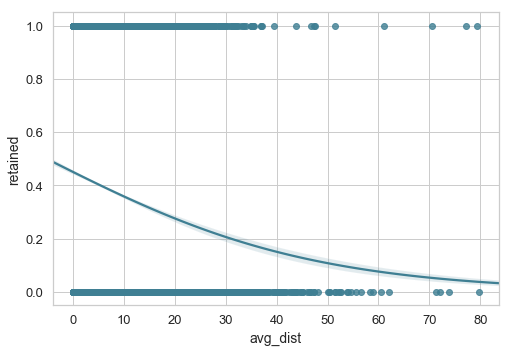

Plotting for avg_rating_by_driver vs. retained.


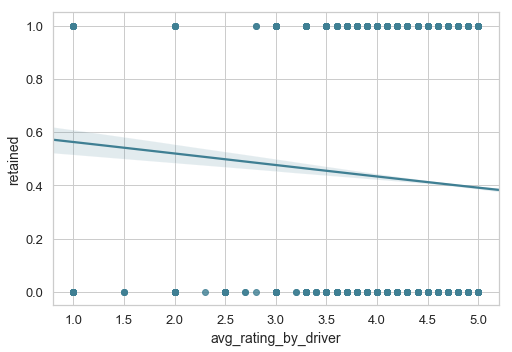

Plotting for avg_rating_of_driver vs. retained.


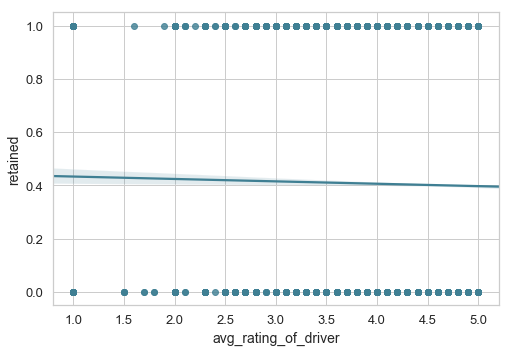

Plotting for avg_surge vs. retained.


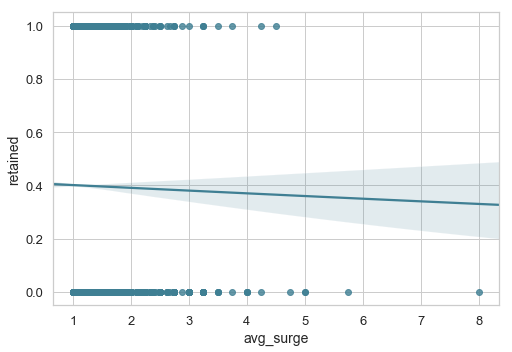

Plotting for surge_pct vs. retained.


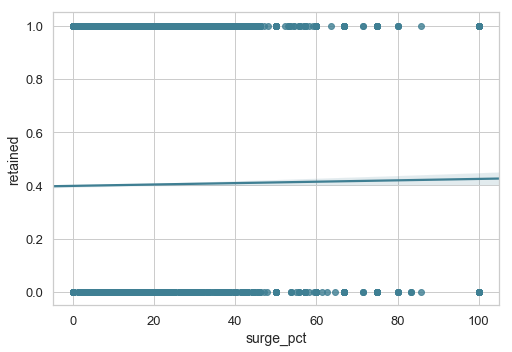

Plotting for trips_in_first_30_days vs. retained.


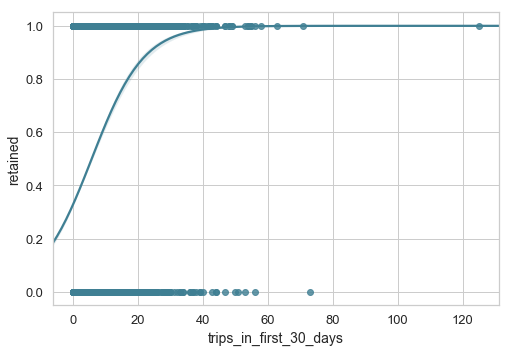

Plotting for ultimate_black_user vs. retained.


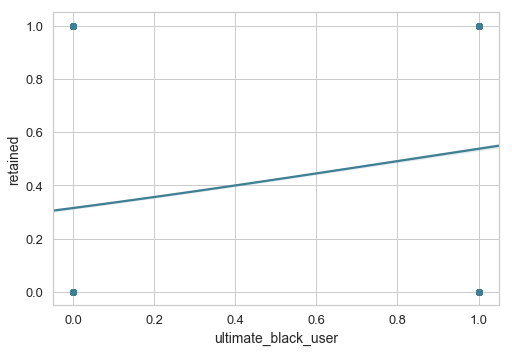

Plotting for weekday_pct vs. retained.


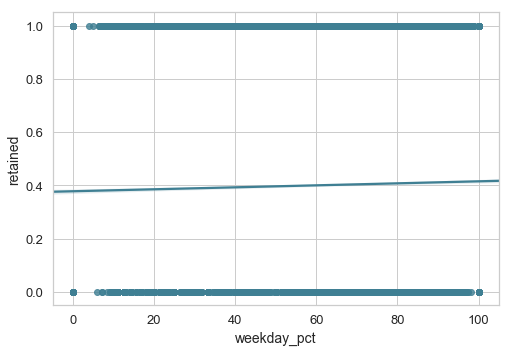

Plotting for city_Astapor vs. retained.


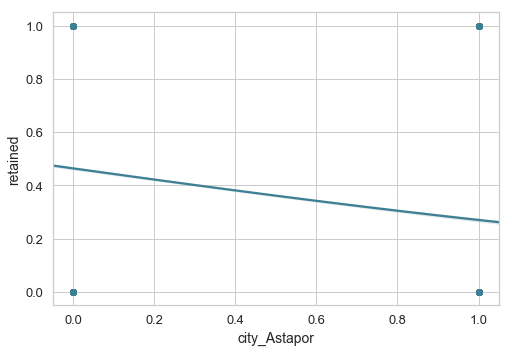

Plotting for city_King's Landing vs. retained.


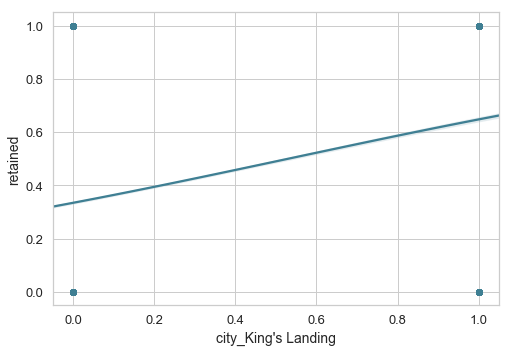

Plotting for city_Winterfell vs. retained.


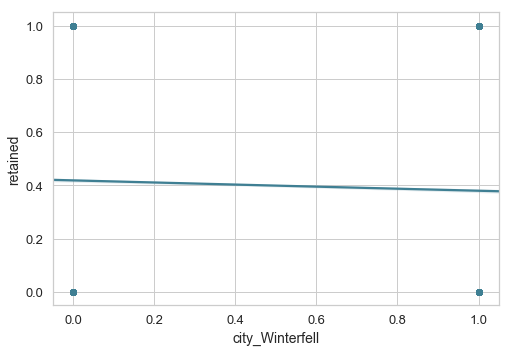

Plotting for phone_Android vs. retained.


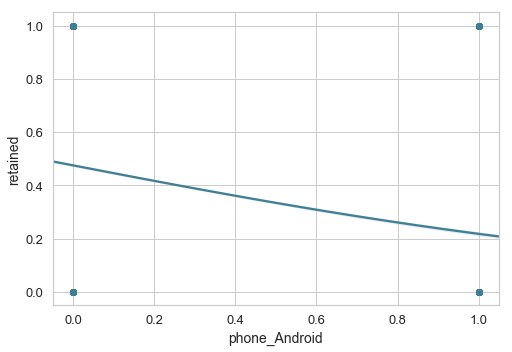

Plotting for phone_iPhone vs. retained.


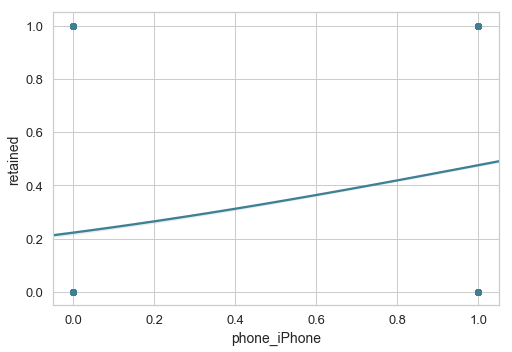

Plotting for signup_date_delta vs. retained.


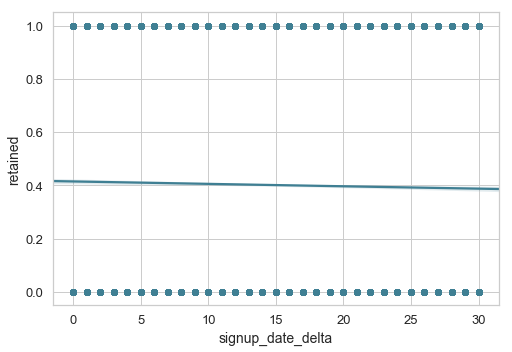

In [35]:
# Plot feature vs. target with logistic regression for each feature.
for feature in features:
    print('Plotting for ' + feature + ' vs. retained.')
    plot_scatter(x = feature, y = 'retained', df = df_rider, logistic = True)

**From the above plots, we can see some trends for each feature vs. target, i.e., feature vs. whther the rider is retained. I also observed that, **
1. **Riders whose signed up city is King's Landing are retained better while Rider whose signed up city is Astapor are not.**
2. **In addition, riders whose phone is iphone are retained better while riders whose phone is android are not.**

## Modeling
> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

As we would like to predict whether a user is retained, it's naturally a binary classification problem.

Let's try the following models:
1. K-Nearest Neighbors
2. Logistic Regression
3. Random Forest
4. Gradient Boosting

#### Train-Test-Split, Cross-Validation & Standardization
Let's also use train_test_split to do train-test split, GridSearchCV to do cross-validation & use StandardScaler to standardize the data.

#### Evaluation
Since it's a binary classification problem, let's use confusion matrix and f1 score for evaluation.

Reference: https://en.wikipedia.org/wiki/F1_score

In [36]:
def get_X_y(df, features, target):
    X = df[features].as_matrix()
    y = df[target].as_matrix()
    
    return (X, y)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def score_and_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    # plot confusion matrix
    df_cm = pd.DataFrame(cm)
    ax = get_sub_plot()
    sns.heatmap(df_cm, cmap = palette, annot = True, ax = ax)
    plt.show()
    
    score = f1_score(y_test, y_pred)
    print('F1 Score:', score)
    
    return score

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Models = ['knn', 'logistic', 'rf', 'gb']

def model(model_mode, X, y):
    if model_mode not in Models:
        print('Mode not defined')
        return
    
    steps = [('scaler', StandardScaler())]
    
    if model_mode == 'knn':
        steps += [('knn', KNeighborsClassifier())]
        param_grid = {'knn__n_neighbors': np.arange(3, 50)}
    elif model_mode == 'logistic':
        steps += [('logistic', LogisticRegression(penalty = 'l1', random_state = 42))]  
        param_grid = {'logistic__C': [1.0, 0.5, 0.1, 0.05, 0.025, 0.01]}          
    elif model_mode == 'rf':
        steps = [('rf', RandomForestClassifier(random_state = 42))]
        param_grid = {'rf__n_estimators': np.arange(10, 100, 10),
                      'rf__max_depth' : np.arange(10, 100, 10)}
    elif model_mode == 'gb':
        steps += [('gb', GradientBoostingClassifier(random_state = 42))]
        param_grid = {'gb__n_estimators': np.arange(10, 100, 10),
                      'gb__max_depth' : np.arange(10, 100, 10)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model:', model_mode)
    print('    Best Params:', cv.best_params_)
    
    if model_mode == 'logistic':
        print('    Coefficients:', cv.best_estimator_.named_steps[model_mode].coef_)
    elif model_mode == 'rf' or model_mode == 'gb':
        print('    Feature Importances:', cv.best_estimator_.named_steps[model_mode].feature_importances_)

    y_pred = cv.predict(X_test)
    
    f1_score = score_and_plot(y_test, y_pred)
        
    return (y_test, y_pred, f1_score)

def try_all_models(X, y):
    modelScores = {}
    for m in Models:
        y_test, y_pred, score = model(model_mode = m, X = X, y = y)
        modelScores[m] = score          
    return modelScores

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
target = 'retained'

print('Features:', features)
print('Target:', target)

X, y = get_X_y(df_rider, features, target)

Features: ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_Android', 'phone_iPhone', 'signup_date_delta']
Target: retained


Model: knn
    Best Params: {'knn__n_neighbors': 49}


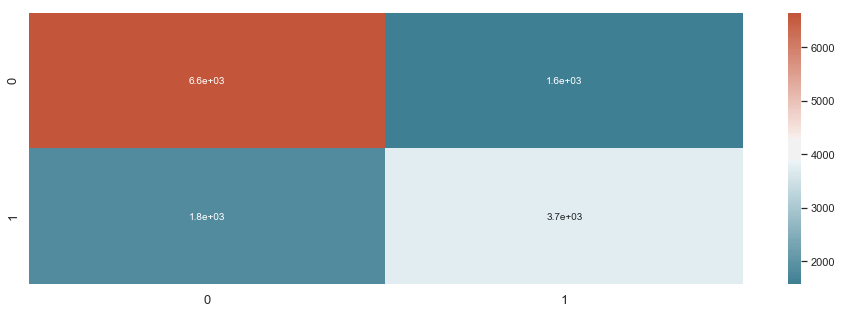

F1 Score: 0.6883104938839326
Model: logistic
    Best Params: {'logistic__C': 0.01}
    Coefficients: [[-0.16592683 -0.08387491 -0.0176934   0.          0.01406345  0.41557193
   0.42888838  0.00744433 -0.25708044  0.47555746  0.         -0.30009836
   0.20625542 -0.0343794 ]]


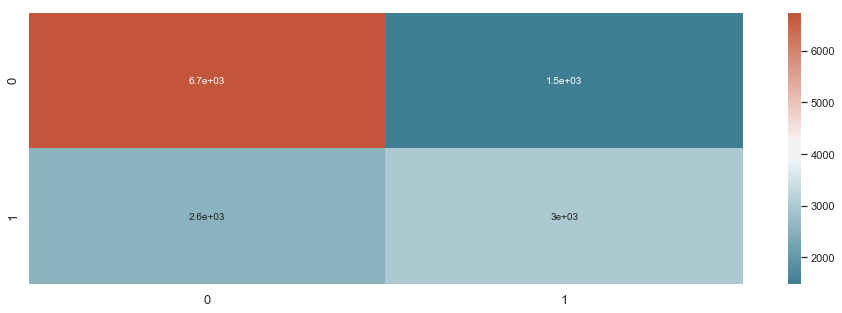

F1 Score: 0.599362803663879
Model: rf
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 90}
    Feature Importances: [0.055705   0.17734323 0.0386806  0.07874137 0.11940211 0.04365357
 0.06236493 0.1132213  0.03659128 0.11162425 0.02217793 0.05812803
 0.04689652 0.03546988]


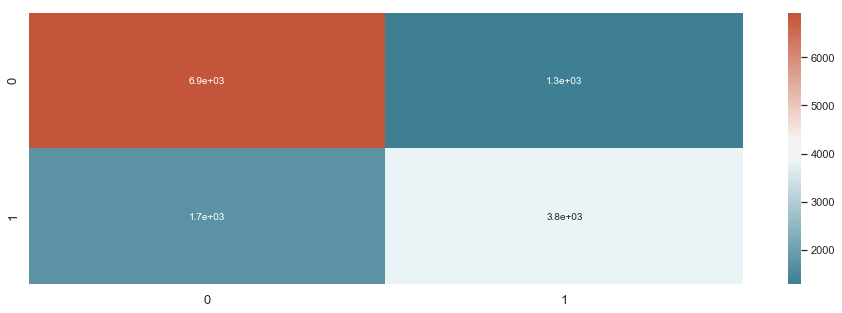

F1 Score: 0.7164962956016131
Model: gb
    Best Params: {'gb__max_depth': 10, 'gb__n_estimators': 50}
    Feature Importances: [0.2478061  0.12187154 0.06862125 0.04510607 0.06777146 0.08015511
 0.0273422  0.12618557 0.01310456 0.04905105 0.00746644 0.0215164
 0.01434291 0.10965934]


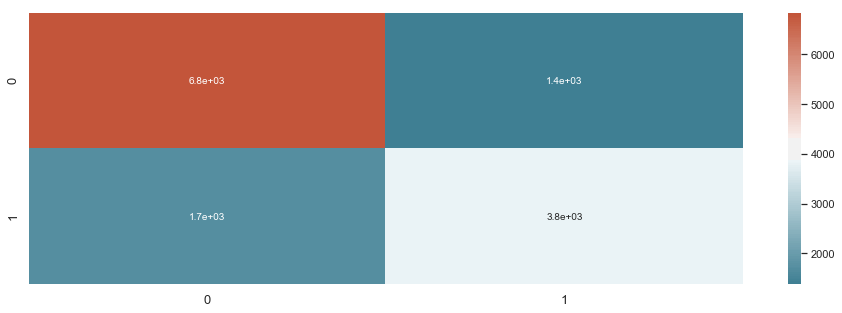

F1 Score: 0.7133320971629891


In [40]:
modelScores = try_all_models(X, y)

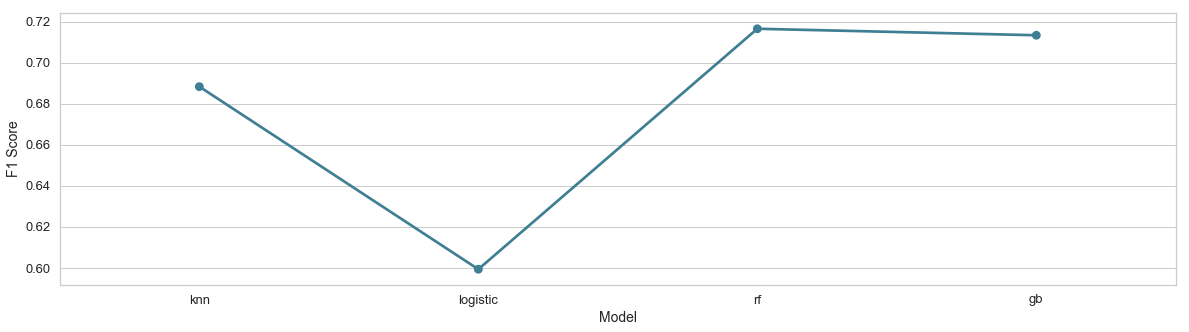

In [41]:
# Compare F1 score of each model
modelScoresDf = pd.DataFrame(list(modelScores.items()))
modelScoresDf.columns = ['Model', 'F1 Score']

fig, axes = get_sub_plots(1, 1)
sns.pointplot(x = "Model", y = "F1 Score", data = modelScoresDf, ax = axes[0])
plt.show()

**Looking at the above plot, random forest model has the best F1 score. This model can be a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.**

**In addition, we can look at the feature importances of random forest model, the most import features are: avg_rating_by_driver, surge_pct, weekday_pct and city.**

## Conclusion
> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

**With the exploratory data analysis and predictive model, we found avg_rating_by_driver, surge_pct, weekday_pct and city are key features for predicting rider retention. They can also be used to maintain / improve the rider retention. For example, Ultimate can focus more on riders whose sign up city is Astapor since their retention seem not good. Ultimate should also focus more on improving Android application user experience since their retention is not good.**